In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from ParticleFilter import sample_normal_model, normal_model_p, particle_filter, single_step_particle_filter
from static_beacons_model import agent_transition_model_template ,becon_transition_model_template, agent_measurement_model_template, measurement_likelihood_template
from files_handlers import save_experiment_results
import sys
import time
import os

In [4]:
# problem parameters

beacons_pos = 2.5
beacons = beacons_pos*np.array([[1, 1], [-1, -1], [-1, 1], [1, -1]])
x0 = np.array([0, 0])
sigma_transition = 0.3
sigma_measurement = 0.1
stepsize = 1
n_steps = 100
note = ''
# filter parameters
n_particles = 1000
resample_method='stratified'
# model definition
cov_measurement = (sigma_measurement**2)*np.eye(4)
cov_transition = (sigma_transition**2)*np.eye(2)

agent_transition_model = lambda x, u: agent_transition_model_template(x, u, cov_transition)
becons_transition_model = lambda becons, u: becons
agent_measurement_model = lambda x : agent_measurement_model_template(x, beacons, sigma_measurement)
measurement_likelihood = lambda z, x : measurement_likelihood_template(z, x, beacons, cov_measurement)

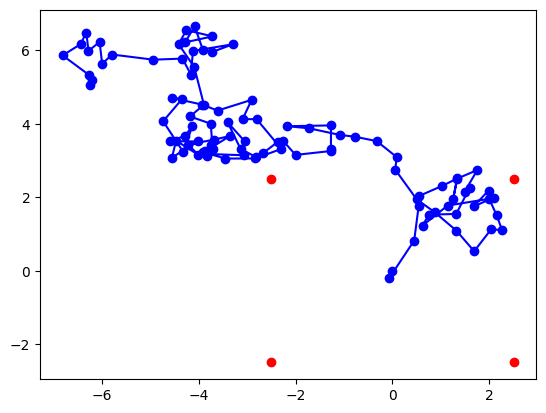

In [5]:
# create ground truth
u_agent = (np.random.rand(n_steps, 2) - 0.5)*stepsize
x = np.zeros((n_steps, 2))
xi = x0
z = np.zeros((n_steps, 4))
for i in range(0, n_steps):
    x[i] = xi
    z[i] = agent_measurement_model(xi)
    xi = agent_transition_model(xi, u_agent[i])

# plot ground truth
plt.figure()
plt.plot(x[:, 0], x[:, 1], 'bo-')
plt.plot(beacons[:, 0], beacons[:, 1], 'ro')
plt.show()

In [8]:
#create a folfder to store the current experiment results
save_experiment_results(n_particles, n_steps, resample_method, note, beacons_pos, sigma_transition, sigma_measurement, stepsize, x, z)

MovieWriter imagemagick unavailable; using Pillow instead.


0/100

99/100

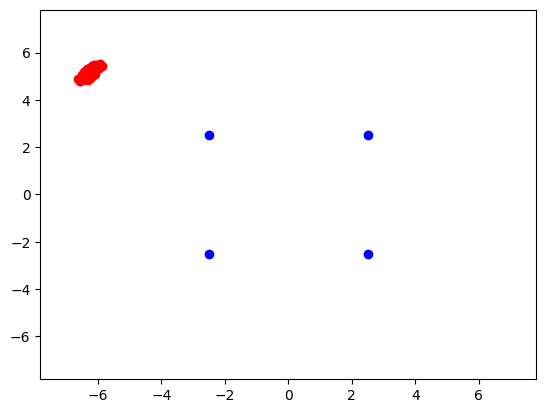

In [9]:
dict_stats = {'mean': list(np.zeros((n_steps, 2))), 'std': list(np.zeros((n_steps, 2)))}
particles = (np.random.rand(n_particles, 2)-0.5)*4
fig, ax = plt.subplots()
sc_path, = ax.plot([], [], c='g',marker='o')
sc = ax.scatter([], [], color='red')
sc_beacons = ax.scatter(beacons[:, 0], beacons[:, 1], c='b')
lim = np.max(np.abs(x)) + 1 
def init():
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    sc_path.set_data([], [])
def animate(i):
    global particles
    sc_path.set_data(x[:i, 0],x[:i, 1])
    sc.set_offsets(particles)
    print(f"\r{i}/{n_steps}", end='', flush=True)
    particles = single_step_particle_filter(particles, u_agent[i], z[i], agent_transition_model, measurement_likelihood,resample_method)
    dict_stats['mean'][i] = np.mean(particles, axis=0)
    dict_stats['std'][i] = np.std(particles, axis=0)
    return sc, sc_path
ani = animation.FuncAnimation(fig, animate, frames=n_steps, init_func=init, interval=500)
ani.save(f'{exp_folder_name}/movie.gif', writer='imagemagick')

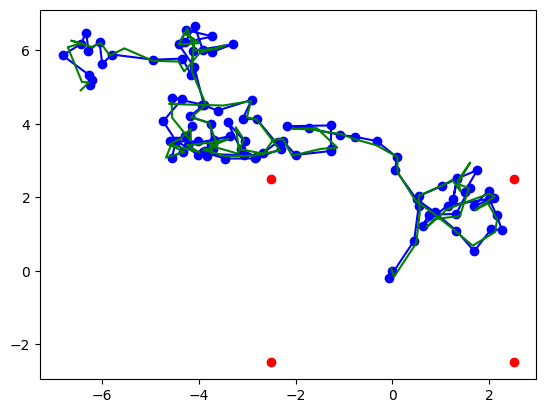

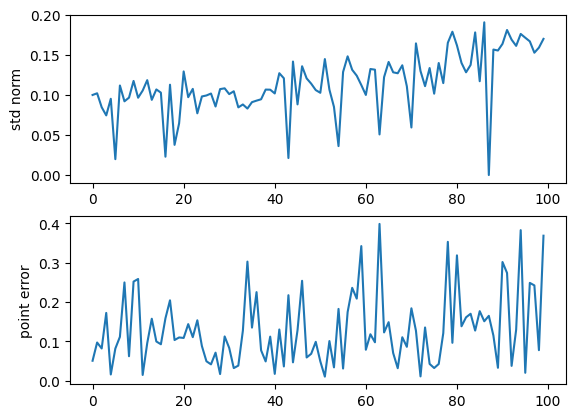

In [10]:
#plot ground truth and estimated path:
plt.figure()
plt.plot(x[:, 0], x[:, 1], 'bo-')
plt.plot(beacons[:, 0], beacons[:, 1], 'ro')
plt.plot(np.array(dict_stats['mean'])[:, 0], np.array(dict_stats['mean'])[:, 1], 'g-')
plt.savefig(f'{exp_folder_name}/path.png')
plt.show()
#plot std norm
fig =plt.figure()
ax = fig.add_subplot(211)
ax.plot(np.linalg.norm(dict_stats['std'], axis=1))
ax.yaxis.label.set_text('std norm')
# plot positon error
ax = fig.add_subplot(212)
ax.plot(np.linalg.norm(x - np.array(dict_stats['mean']), axis=1))
ax.yaxis.label.set_text('point error')
plt.savefig(f'{exp_folder_name}/stats.png')
plt.show()
#save mean
np.savetxt(f'{exp_folder_name}/stats_mean.csv', np.array(dict_stats['mean']), delimiter=',',header='x,y')
#save std
np.savetxt(f'{exp_folder_name}/stats_std.csv', np.array(dict_stats['std']), delimiter=',',header='x,y')

